In [1]:
%matplotlib inline

import gc
import os
import sys
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
from scipy.stats import mode
import pickle
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt

import textract
import docx2txt
import PyPDF2
from PyPDF2 import PdfFileReader
import glob
import optuna

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn import preprocessing
import joblib
from striprtf.striprtf import rtf_to_text

from lightgbm import LGBMClassifier, LGBMRegressor, log_evaluation
from lightgbm import early_stopping
from catboost import CatBoostClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from transformers import AutoTokenizer, AutoModel

from IPython.display import clear_output

target = 'label'
path = '../input/dataset/'

clear_output(wait = False)

In [2]:
dtrain = pd.DataFrame(columns = ['text', 'label'])

path = '../input/dataset/'

paths = os.listdir(path)
paths.remove('readme.md')
paths.remove('sample.csv')
paths = sorted(paths)
paths

['act',
 'application',
 'arrangement',
 'bill',
 'contract',
 'contract_offer',
 'determination',
 'invoice',
 'order',
 'proxy',
 'statute']

In [3]:
for label in paths:
    doc_list = (
        glob.glob(path + label + '/*.rtf') + 
        glob.glob(path + label + '/*.RTF') + 
        glob.glob(path + label + '/*.pdf')
    )
    for path_doc in doc_list:
                
        if ('.rtf' in path_doc) or ('.RTF' in path_doc):            
            try:
                with open(path_doc) as infile:
                    content = infile.read()
                    text = rtf_to_text(content)
                    text = text.split(' ')[:1000] # первая тысяча слов
                    text = ' '.join(text)            
                
                L = dtrain.shape[0]
                dtrain.loc[L, 'text'] = text                    
                dtrain.loc[L, 'label'] = label
            except:
                print('error in :', path_doc)
                pass
            
        elif '.pdf' in path_doc:
            text = ''
            with open(path_pdf, "rb") as filehandle:  
                try:
                    pdf = PdfFileReader(filehandle)
                    info = pdf.getDocumentInfo()
                    pages = pdf.getNumPages()   
                    #print (info)
                    #print ("number of pages: %i" % pages)   
                    for y in range(pages):
                        page = pdf.getPage(y)
                        page = page.extractText()
                        text += page
                    
                    text = text.split(' ')[:1000] # первая тысяча слов
                    text = ' '.join(text)
                    L = dtrain.shape[0]
                    dtrain.loc[L, 'text'] = text                  
                    dtrain.loc[L, 'label'] = label
                except:
                    print('error in :', path_doc)
                    pass

        
dtrain = dtrain[dtrain['text'] == dtrain['text']]    
dtrain = dtrain[dtrain['text'] != '']
dtrain = dtrain[dtrain['text'] != ' '] 
dtrain.to_csv('dtrain.csv', index = False)   
print(dtrain.info())

error in : ../input/dataset/act/document_act.rtf
error in : ../input/dataset/act/Akt.rtf
error in : ../input/dataset/act/avariynyy-akt-po-torgovo-tekhnologicheskomu-oborudovaniyu.rtf
error in : ../input/dataset/application/заявление.rtf
error in : ../input/dataset/bill/apellyatsionnaya_galoba_na_reshenie_suda_pervoy_instantsii_po_gragdanskim_delam.rtf
error in : ../input/dataset/contract_offer/puboferta.rtf
error in : ../input/dataset/determination/rechenie verchovnogo suda.rtf
<class 'pandas.core.frame.DataFrame'>
Index: 961 entries, 0 to 960
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    961 non-null    object
 1   label   961 non-null    object
dtypes: object(2)
memory usage: 54.8+ KB
None


In [54]:
use = ['text']
temp = dtrain.drop_duplicates(subset = use)
dublicates = dtrain[use][~dtrain.index.isin(temp.index)]
print(len(dublicates))

0


In [55]:
dublicates

,text


In [56]:
dtrain[target].value_counts().sort_index()

label
0      13
1      13
2       6
3       4
4     108
5      15
6      12
7      10
8     259
9       7
10     10
Name: count, dtype: int64

/home/vlad/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='label', ylabel='Count'>

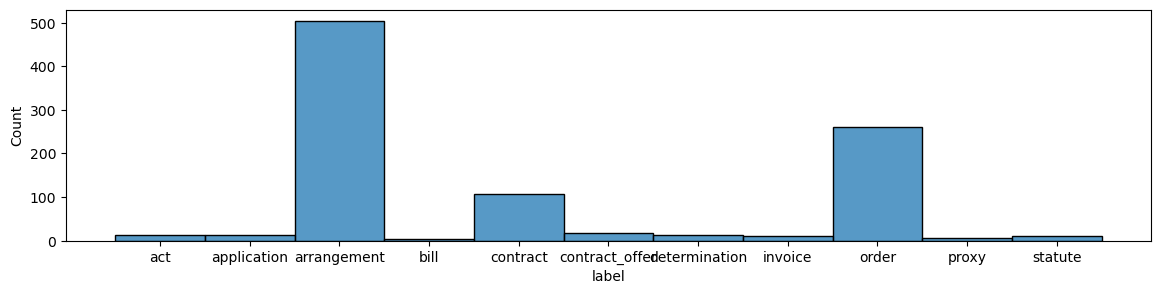

In [7]:
plt.figure(figsize = (14, 3))
sns.histplot(dtrain[target])

In [8]:
from nltk.corpus import stopwords
import string
import re

def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('russian'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count


def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    
    return dataframe

In [9]:
dtrain = feature_engineer(dtrain)
dtrain.head()

,text,label,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
0,Акт сверки|\nвзаимных расчетов по состоянию на...,act,79,1085,19,579,0
1,\n\nАВАРИЙНЫЙ АКТ\n\n ...,act,737,2481,14,1015,4
2,ОБРАЗЕЦ ...,act,693,3090,12,1657,2
3,Форма 2\n(в ред. Приказов Минтруда России \nот...,act,487,4463,82,256,39
4,\n\n\n\n\n\nАКТ\nсдачи приемки работ\n\nпо Дог...,act,77,886,15,297,13


In [10]:
import re
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer

morph = MorphAnalyzer()
stop_words = stopwords.words('russian')
stop_words.append('г')
#stop_words.append('год')
#stop_words.append('гр')
#stop_words.append('рф')

def clear_text(text):
    
    text = " ".join((re.sub(r'[^-а-яА-ЯёЁ]', ' ', text).split())).lower()    
    
    out = []
    for token in text.split():
        token = morph.normal_forms(token)[0]
        out.append(token)
    
    text = " ".join(out)
    text = " ".join([word for word in text.split() if word not in stop_words])
    
    return text

dtrain['text'] = dtrain['text'].apply(lambda x: clear_text(str(x)))

In [11]:
dtrain['text'].sample(10)

395    - - - защита документ крупный сеть база судебн...
938    министерство промышленность торговля российски...
633    договор зона свободный торговля санкт-петербур...
406    - - - защита документ крупный сеть база судебн...
597    утвердить решение правление государственный ко...
351    - - - защита документ крупный сеть база судебн...
199    - - - защита документ крупный сеть база судебн...
235    - - - защита документ крупный сеть база судебн...
928    министерство природный ресурс экология российс...
623    договор июнь год российский федерация мексикан...
Name: text, dtype: object

In [12]:
use = ['text']
temp = dtrain.drop_duplicates(subset = use)
dublicates = dtrain[use][~dtrain.index.isin(temp.index)]
print(len(dublicates))

504


In [13]:
dublicates

,text
27,- - - защита документ крупный сеть база судебн...
28,- - - защита документ крупный сеть база судебн...
29,- - - защита документ крупный сеть база судебн...
30,- - - защита документ крупный сеть база судебн...
31,- - - защита документ крупный сеть база судебн...
...,...
649,договор-оферта интернет-магазин ооо интернет-м...
659,договор-оферта ооо агросемфонд интернет-магази...
664,дело - заочный решение имя российский федераци...
682,счёт поставщик публичный акционерный общество ...


In [14]:
dtrain = dtrain.drop_duplicates(subset = use, keep = 'first')
dtrain[target].value_counts().sort_index()

label
act                13
application        13
arrangement         6
bill                4
contract          108
contract_offer     15
determination      12
invoice            10
order             259
proxy               7
statute            10
Name: count, dtype: int64

In [15]:
le = preprocessing.LabelEncoder()
dtrain[target] = le.fit_transform(dtrain[target])

joblib.dump(le, 'le.pkl')

['le.pkl']

In [16]:
dtrain[target].value_counts().sort_index()

label
0      13
1      13
2       6
3       4
4     108
5      15
6      12
7      10
8     259
9       7
10     10
Name: count, dtype: int64

In [17]:
from sklearn.utils.class_weight import compute_class_weight

values = compute_class_weight(
    class_weight = "balanced", 
    classes = np.unique(dtrain[target]), 
    y = dtrain[target]
)
keys = list(np.unique(dtrain[target]))

class_weight = dict(zip(keys, values))
#class_weight = torch.tensor(values, dtype = torch.float32)
class_weight

{0: 3.195804195804196,
 1: 3.195804195804196,
 2: 6.924242424242424,
 3: 10.386363636363637,
 4: 0.3846801346801347,
 5: 2.7696969696969695,
 6: 3.462121212121212,
 7: 4.154545454545454,
 8: 0.1604071604071604,
 9: 5.935064935064935,
 10: 4.154545454545454}

In [18]:
dtrain.shape

(457, 7)

In [49]:
dtrain.head()

,text,label,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
0,акт сверка взаимный расчёт состояние нижеподпи...,0,79,1085,19,579,0
1,аварийный акт утвердить приказ минторг аварийн...,0,737,2481,14,1015,4
2,образец приложение акт предоставление коммунал...,0,693,3090,12,1657,2
3,форма ред приказ минтруд россия н н форма н- э...,0,487,4463,82,256,39
4,акт сдача приёмка работа договор - - - состави...,0,77,886,15,297,13


In [19]:

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

In [20]:
import torch

def embed(data, cls = True, length = 256, test = False):
    
    col = list(data.columns).index('text')
    
    emb = np.zeros([1, 312])
    batch_size = 2

    for index in range(0, len(data), batch_size):

        batch = list(data.iloc[index: min(index + batch_size, data.shape[0]), col])
        
        encoded_input = tokenizer(
            batch, 
            padding = True, 
            truncation = True, 
            return_tensors = 'pt', 
            max_length = length
        )

        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in encoded_input.items()})
        if cls:
            embeddings = model_output.last_hidden_state[:, 0, :]
        else:
            embeddings = model_output.pooler_output
            
        embeddings = torch.nn.functional.normalize(embeddings)
        emb = np.vstack((emb, embeddings))

    return emb[1:]

In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    dtrain, dtrain[target], 
    test_size = 0.1, 
    random_state = 0, 
    stratify = dtrain[target]
)

In [22]:
%%time
X_train = pd.DataFrame(embed(X_train, test = False, cls = False))
use = ['emb_' + str(f) for f in range(X_train.shape[1])]
X_train.columns = use
print(X_train.shape)

(411, 312)
CPU times: user 1min 10s, sys: 1.03 s, total: 1min 11s
Wall time: 5.57 s


In [50]:
X_train.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_302,emb_303,emb_304,emb_305,emb_306,emb_307,emb_308,emb_309,emb_310,emb_311
0,-0.008557,0.003858,0.001475,-0.121348,0.033599,-0.064271,-0.047179,0.017594,-0.084463,0.052590,...,-0.073254,-0.010193,-0.067903,0.043604,0.027938,0.041976,0.013158,-0.050770,-0.010743,-0.107784
1,0.058250,0.002162,-0.067439,0.019783,0.017154,-0.016434,0.004362,0.046139,-0.091834,0.065572,...,-0.054616,-0.041154,-0.062303,0.030366,-0.070403,-0.095763,0.022199,-0.055555,-0.015677,-0.121820
2,0.023285,-0.006800,-0.066425,-0.002580,0.035438,-0.065096,0.004915,0.031700,-0.064095,0.086592,...,-0.039438,-0.060129,0.009201,0.061547,-0.061499,-0.089537,0.014510,-0.082336,0.017147,-0.102045
3,0.037887,-0.006275,-0.079728,0.002843,0.009522,-0.028598,-0.003197,0.038906,-0.071548,0.050789,...,-0.034567,-0.063413,-0.036688,0.037228,-0.047529,-0.087246,0.045779,-0.050495,-0.000444,-0.132823
4,0.043791,-0.013344,-0.041646,0.005206,0.017365,-0.065891,-0.001420,0.056219,-0.079051,0.086488,...,0.009147,-0.008638,0.007135,0.053163,-0.034327,-0.069658,0.052193,-0.069621,0.025878,-0.101941


In [23]:
%%time
X_val = pd.DataFrame(embed(X_val, test = False, cls = False))
X_val.columns = use
print(X_val.shape)

(46, 312)
CPU times: user 8.79 s, sys: 227 ms, total: 9.01 s
Wall time: 656 ms


In [24]:
model = LogisticRegression(C = 1e3, class_weight = class_weight)
model.fit(X_train, y_train)

LogisticRegression(C=1000.0,
                   class_weight={0: 3.195804195804196, 1: 3.195804195804196,
                                 2: 6.924242424242424, 3: 10.386363636363637,
                                 4: 0.3846801346801347, 5: 2.7696969696969695,
                                 6: 3.462121212121212, 7: 4.154545454545454,
                                 8: 0.1604071604071604, 9: 5.935064935064935,
                                 10: 4.154545454545454})

In [25]:
y_pred = model.predict(X_val)
f1_score(y_val, y_pred, average = 'weighted')

0.8851458192150848

In [26]:
def get_score():
    models = []
    SEEDS = 1
    
    params = {
        'max_depth': -1,
        'learning_rate': 0.03,
        'num_leaves': 128,
        'subsample': 1,
        'subsample_freq': 1,
        'colsample_bytree': 0.9,
        'reg_alpha': 0.001,
        'reg_lambda': 0.001,        
        'n_estimators': 1000,
        'random_state': 0,
        'verbose': -1,
    }
    for seed in range(SEEDS):
        params['random_state'] = seed
        model = LGBMClassifier(**params)
        model.fit(
            X_train,
            y_train,
            eval_set = (X_val, y_val),
            callbacks = [early_stopping(500, verbose = 1000), log_evaluation(1000)],
            #eval_metric = lgb_metric
        )
        models.append(model)
    return models, dict(model.best_score_)['valid_0']['multi_logloss']

In [27]:
models, best = get_score()
y_pred = models[0].predict(X_val)
f1_score(y_val, y_pred, average = 'weighted')

Training until validation scores don't improve for 500 rounds
[1000]	valid_0's multi_logloss: 0.249808
Did not meet early stopping. Best iteration is:
[784]	valid_0's multi_logloss: 0.249808


0.9374291115311909

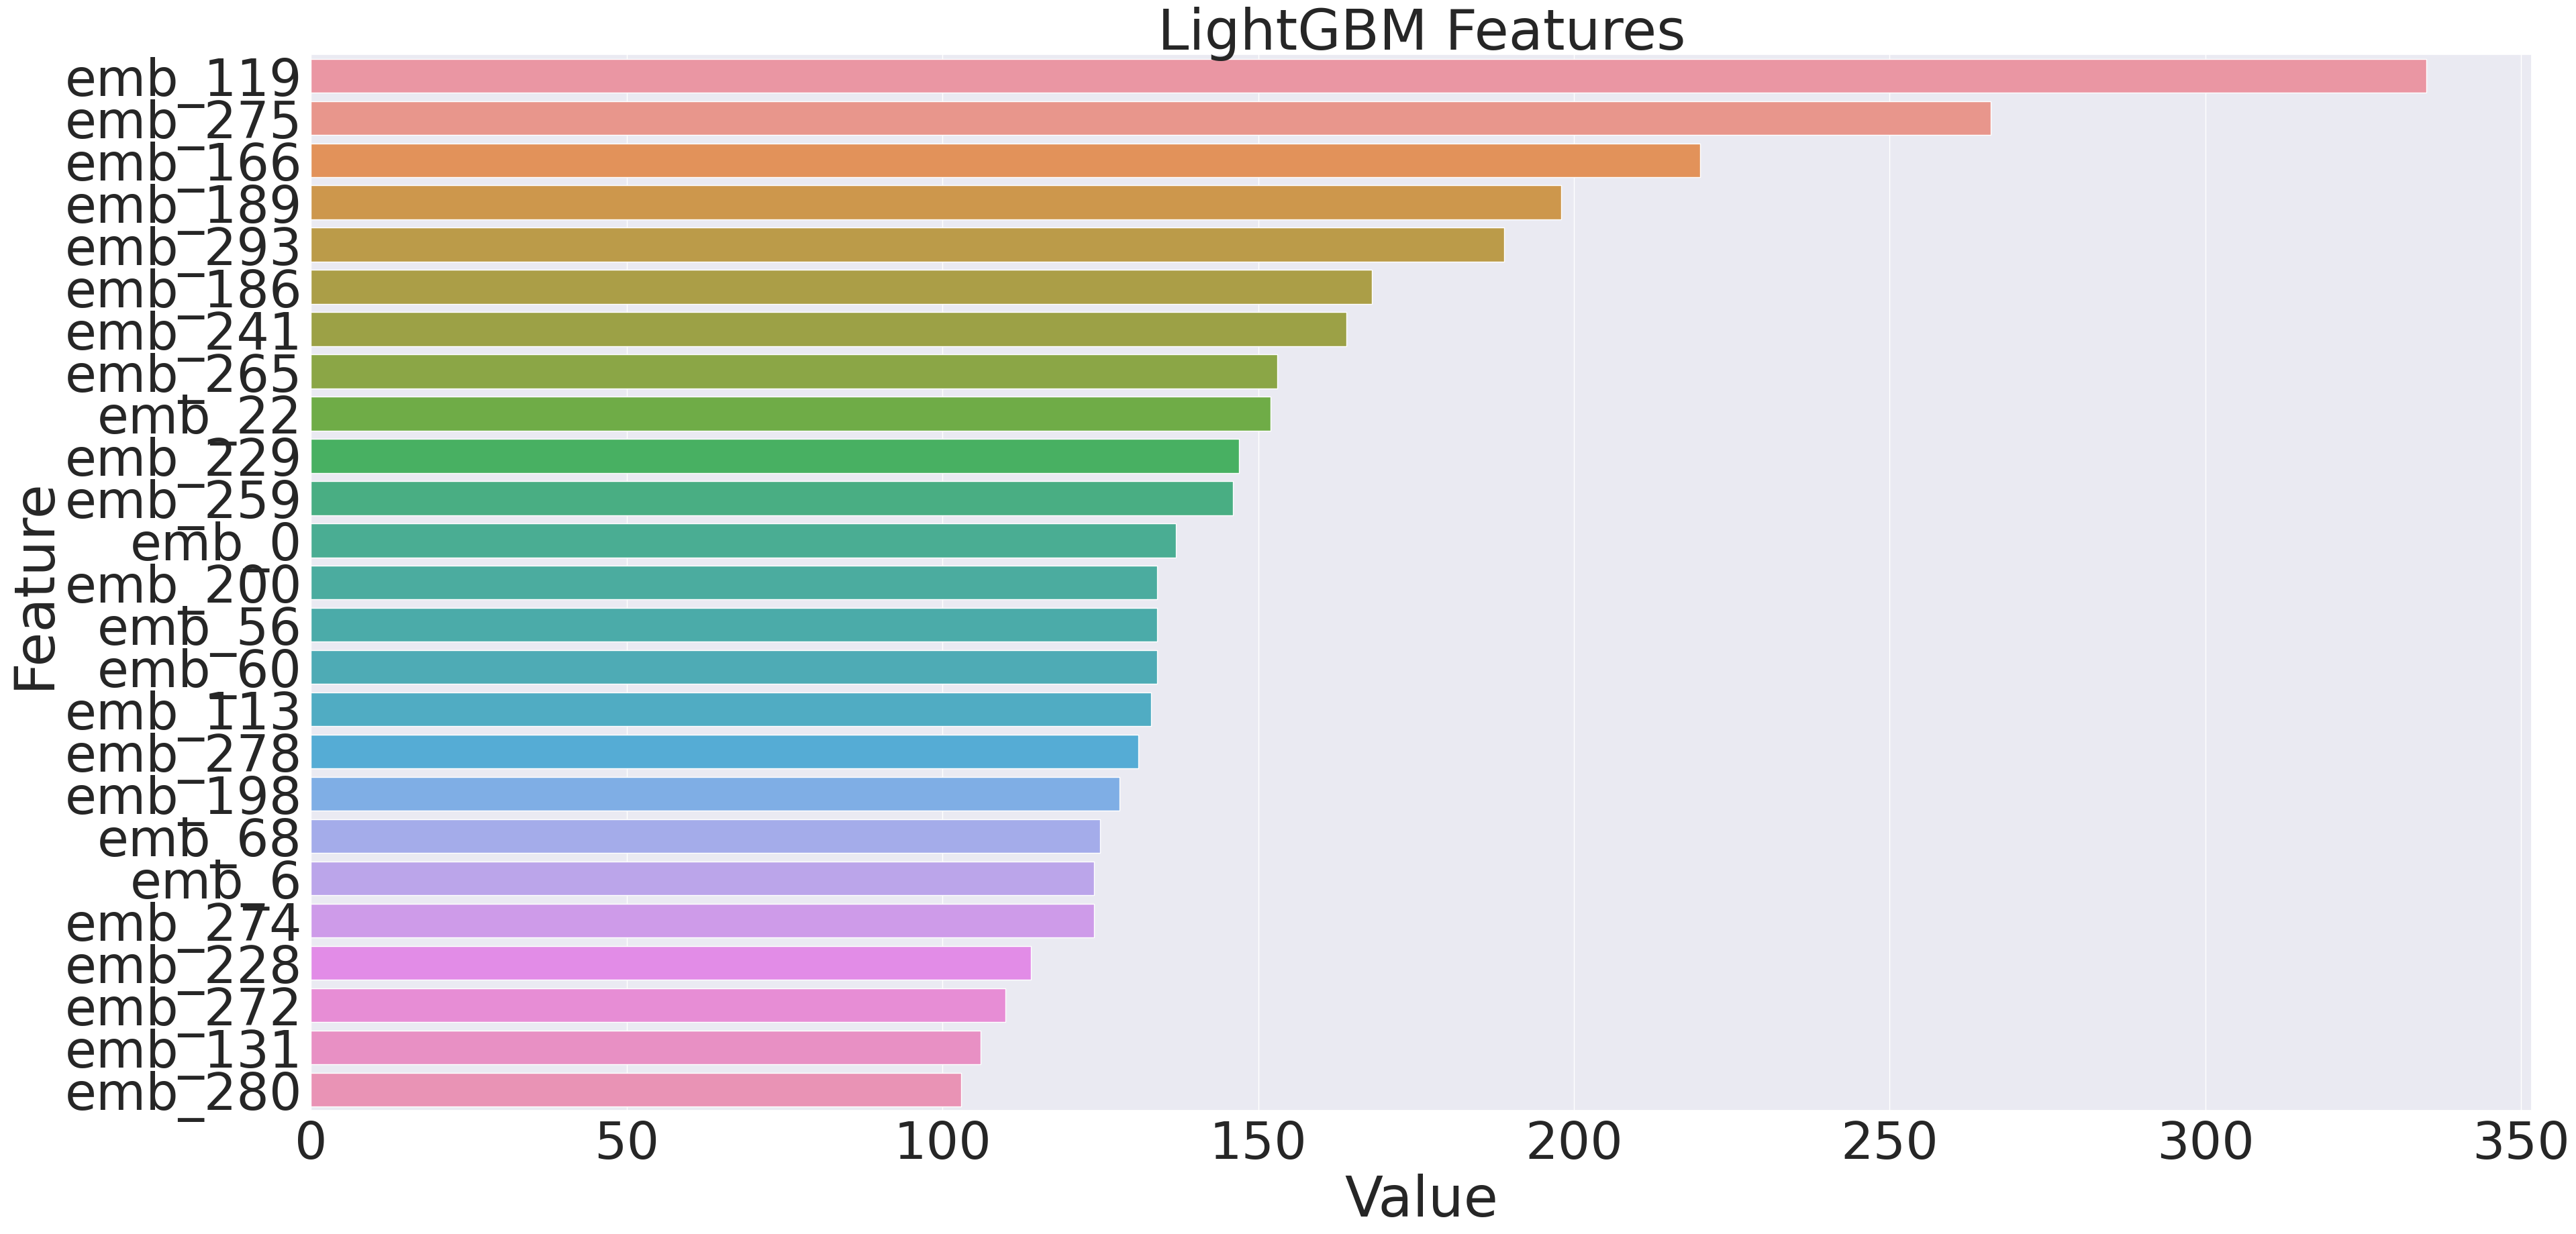

In [28]:
import matplotlib.pyplot as plt

def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_, 'Feature':X.columns})
    plt.figure(figsize = fig_size)
    sns.set(font_scale = 5)
    
    sns.barplot(
        x = "Value", 
        y = "Feature", 
        data = feature_imp.sort_values(by = "Value", ascending = False)[0:num]
    )
    
    plt.title('LightGBM Features')
    plt.tight_layout()
    #plt.savefig('lgbm_importances-01.png')
    plt.show()
    
plotImp(models[0], X_train, num = 25)    

In [29]:
def get_score():
    models = []
    SEEDS = 1
    
    params = {
        'max_depth': 0,
        'learning_rate': 0.03,
        'subsample': 0.975,
        'colsample_bytree': 0.975,
        'reg_alpha': 0.0001,
        'reg_lambda': 0.0001,        
        'n_estimators': 1000,
        'random_state': 0,
        'tree_method': "hist",
        'early_stopping_rounds': 100
        #'device': 'cuda'
    }
    for seed in range(SEEDS):
        params['random_state'] = seed
        model = XGBClassifier(**params)
        model.fit(
            X_train,
            y_train,
            eval_set = [(X_val, y_val)],
            verbose = 100,
        )
        models.append(model)
    return models

In [51]:
models_xgb = get_score()
y_pred = models_xgb[0].predict(X_val)
f1_score(y_val, y_pred, average = 'weighted')

[0]	validation_0-mlogloss:2.27377
[100]	validation_0-mlogloss:0.47252
[200]	validation_0-mlogloss:0.35457
[300]	validation_0-mlogloss:0.34239
[400]	validation_0-mlogloss:0.34169
[433]	validation_0-mlogloss:0.34108


0.906474777377513

In [31]:
param_lgbm = {
    'max_depth': -1,
    'learning_rate': 0.03,
    'num_leaves': 128,
    'subsample': 1,
    'subsample_freq': 1,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.001,
    'reg_lambda': 0.001,        
    'n_estimators': 200,
    'random_state': 0,
    'verbose': -1,
}

param_xgb = {
    'max_depth': 0,
    'learning_rate': 0.03,
    'subsample': 1,
    'colsample_bytree': 0.3,
    'reg_alpha': 0.001,
    'reg_lambda': 0.001,        
    'n_estimators': 200,
    'random_state': 0,
    'tree_method': "hist",
}

In [32]:
base_learners = [
    ('rf', RandomForestClassifier(n_estimators = 100, random_state = 42)),
    ('gb', GradientBoostingClassifier(n_estimators = 100, random_state = 42)),
    ('xgb', XGBClassifier(**param_xgb)),
    ('lgbm', LGBMClassifier(**param_lgbm))
]

In [33]:
# Мета эстиматор
meta_learner = LogisticRegression(C = 1)

In [34]:
skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 0)

stacked_ensemble = StackingClassifier(
    estimators = base_learners, 
    final_estimator = meta_learner, 
    cv = skf
)

In [35]:
# Creating a pipeline 
pipeline = make_pipeline(StandardScaler(), stacked_ensemble)

# Training the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('stackingclassifier',
                 StackingClassifier(cv=StratifiedKFold(n_splits=4, random_state=0, shuffle=True),
                                    estimators=[('rf',
                                                 RandomForestClassifier(random_state=42)),
                                                ('gb',
                                                 GradientBoostingClassifier(random_state=42)),
                                                ('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,...
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=200,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=0, ...)),
                                                ('lgbm',
                                                 LGBMClassifier(colsample_bytree=0.9,
                                                                learning_rate=0.03,
                                                                n_estimators=200,
                                                                num_leaves=128,
                                                                random_state=0,
                                                                reg_alpha=0.001,
                                                                reg_lambda=0.001,
                                                                subsample=1,
                                                                subsample_freq=1,
                                                                verbose=-1))],
                                    final_estimator=LogisticRegression(C=1)))])

In [36]:
# Evaluating the model
y_pred = pipeline.predict(X_val)
f1_score(y_val, y_pred, average = 'weighted')

0.8744661485682279

In [37]:
# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations = 1000,
    task_type = "GPU", # "CPU"
    #learning_rate = 0.1,
    #depth=6,
    loss_function = 'MultiClass',
    eval_metric = 'TotalF1:average=Weighted',
    random_seed = 0,
    verbose = 500,
    use_best_model = True,
    early_stopping_rounds = 100
)

In [38]:
catboost_model.fit(
    X_train, y_train,
    eval_set = (X_val, y_val)
    
)

Learning rate set to 0.096123
0:	learn: 0.7829827	test: 0.7231695	best: 0.7231695 (0)	total: 30.4ms	remaining: 30.4s
bestTest = 0.8822134387
bestIteration = 32
Shrink model to first 33 iterations.


In [39]:
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(
    dtrain, dtrain[target], 
    test_size = 0.1, 
    random_state = 0, 
    stratify = dtrain[target]
)
X_train_cat.head()

,text,label,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
7,акт сдача-приём оказать услуга договор место з...,0,223,1939,47,150,12
868,министерство промышленность торговля российски...,8,224,1930,45,65,33
786,министерство промышленность торговля российски...,8,124,958,26,33,22
934,министерство промышленность торговля российски...,8,180,1638,33,64,20
884,министерство промышленность торговля российски...,8,93,858,19,22,16


In [52]:
from catboost.text_processing import Tokenizer, Dictionary

tokenizer = Tokenizer()
txt = tokenizer.tokenize('министерство промышленность торговля')
txt

['министерство', 'промышленность', 'торговля']

In [41]:
tokenizers = [{
        "tokenizer_id" : "Space",
        "separator_type" : "ByDelimiter",
        "delimiter" : " "
}]
dictionaries = [{
        "dictionary_id" : "BiGram",
        "max_dictionary_size" : "50000",
        "occurrence_lower_bound" : "3",
        "gram_order" : "2"
    }, {
        "dictionary_id" : "Word",
        "max_dictionary_size" : "50000",
        "occurrence_lower_bound" : "3",
        "gram_order" : "1"
}]

feature_calcers = [
    'BoW:top_tokens_count=1000',
    'NaiveBayes',
]

In [53]:
use = [f for f in dtrain.columns if f not in ['label']]
use

['text',
 'text_word_cnt',
 'text_length',
 'text_stopword_cnt',
 'text_punct_cnt',
 'text_number_cnt']

In [43]:
cat_cols = [
    'text_word_cnt', 'text_length', 'text_stopword_cnt', 'text_punct_cnt',
    'text_number_cnt'
]

In [44]:
def objective(trial):
    params = {
        #"learning_rate": trial.suggest_float("learning_rate", 3e-3, 0.1, log = True),
        "depth": trial.suggest_int("depth", 2, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        'l2_leaf_reg': trial.suggest_float("learning_rate", 1e-3, 10, log = True),
        'one_hot_max_size': trial.suggest_categorical('one_hot_max_size', [50, 100, 150, 200, 255]),
        'max_dictionary_size': trial.suggest_int("max_dictionary_size", 5000, 500000),
        'occurrence_lower_bound': trial.suggest_categorical('occurrence_lower_bound', [2, 3, 4, 5]),
        'feature_calcers': trial.suggest_categorical('feature_calcers', ['BoW', 'NaiveBayes', 'BM25']),
        'BoW:top_tokens_count': trial.suggest_categorical(
            'BoW:top_tokens_count', [
                'BoW:top_tokens_count=500', 
                'BoW:top_tokens_count=1000', 
                'BoW:top_tokens_count=2000']
        ),
    }       
    
    
    tokenizers = [{
        "tokenizer_id" : "Space",
        "separator_type" : "ByDelimiter",
        "delimiter" : " "
    }]
    dictionaries = [{
        "dictionary_id" : "BiGram",
        "max_dictionary_size" : str(params['max_dictionary_size']),
        "occurrence_lower_bound" : str(params['occurrence_lower_bound']),
        "gram_order" : '2'
    }, {
        "dictionary_id" : "Word",
        "max_dictionary_size" : str(params['max_dictionary_size']),
        "occurrence_lower_bound" : str(params['occurrence_lower_bound']),
        "gram_order" : '1'
    }]
    feature_calcers = [
        params['BoW:top_tokens_count'],
        params['feature_calcers'],
    ]

    model = CatBoostClassifier(
        
        #learning_rate = params['learning_rate'],
        depth = params['depth'],
        min_data_in_leaf = params['min_data_in_leaf'],
        l2_leaf_reg = params['l2_leaf_reg'],
        one_hot_max_size = params['one_hot_max_size'],
        
        iterations = 100000,
        random_seed = 0,
        loss_function = 'MultiClass',
        eval_metric = 'TotalF1',
        cat_features = cat_cols,
        thread_count = -1,
        task_type = 'GPU',
        text_features = ['text'],
        tokenizers = tokenizers, 
        dictionaries = dictionaries,
        feature_calcers = feature_calcers
    )

    model.fit(
        X_train_cat[use], 
        X_train_cat['label'],
        eval_set = (X_val_cat[use], X_val_cat['label']),
        early_stopping_rounds = 1000,
        verbose = False
    )
    
    #dtest['predict'] = model.predict(dtest[use])
    #dtest['predict'] = dtest['predict'].astype(int)
    #y_pred = dtest['predict']
    
    y_pred = model.predict(X_val_cat[use])
    
    sc = f1_score(X_val_cat['label'], y_pred, average = 'weighted')
    
    return sc

In [45]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 5)

[I 2024-04-14 14:24:35,182] A new study created in memory with name: no-name-8c056702-ef4e-4837-9989-c4d6b2580e90
[I 2024-04-14 14:24:43,068] Trial 0 finished with value: 0.9386108832376265 and parameters: {'depth': 6, 'min_data_in_leaf': 28, 'learning_rate': 3.732171619409621, 'one_hot_max_size': 150, 'max_dictionary_size': 25298, 'occurrence_lower_bound': 5, 'feature_calcers': 'BM25', 'BoW:top_tokens_count': 'BoW:top_tokens_count=500'}. Best is trial 0 with value: 0.9386108832376265.
[I 2024-04-14 14:25:13,543] Trial 1 finished with value: 0.9420289855072462 and parameters: {'depth': 9, 'min_data_in_leaf': 48, 'learning_rate': 0.01375898404268516, 'one_hot_max_size': 50, 'max_dictionary_size': 131458, 'occurrence_lower_bound': 2, 'feature_calcers': 'BM25', 'BoW:top_tokens_count': 'BoW:top_tokens_count=2000'}. Best is trial 1 with value: 0.9420289855072462.
[I 2024-04-14 14:25:17,394] Trial 2 finished with value: 0.9386108832376265 and parameters: {'depth': 2, 'min_data_in_leaf': 93, 

In [46]:
study.best_params

{'depth': 3,
 'min_data_in_leaf': 15,
 'learning_rate': 0.011337509978404992,
 'one_hot_max_size': 200,
 'max_dictionary_size': 203850,
 'occurrence_lower_bound': 4,
 'feature_calcers': 'BM25',
 'BoW:top_tokens_count': 'BoW:top_tokens_count=1000'}

In [47]:
import umap

manifold = umap.UMAP().fit(X_train, y_train)
X_trn_reduced = manifold.transform(X_train)
X_val_reduced = manifold.transform(X_val)

clear_output(wait = False)

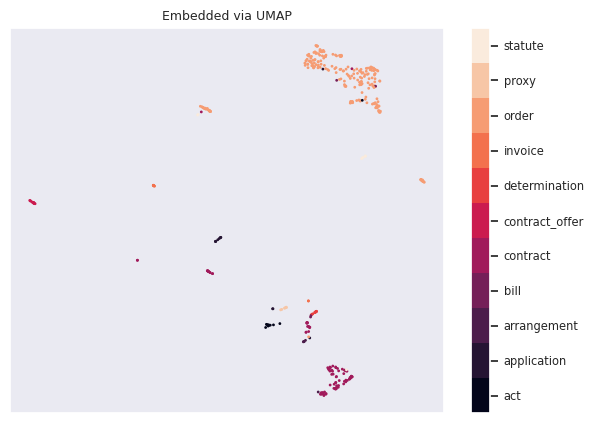

In [48]:
le = joblib.load('le.pkl')

fig, ax = plt.subplots(1, figsize=(7, 5))
classes = list(le.classes_)
sns.set(font_scale = 0.75)

plt.scatter(X_trn_reduced[:, 0], X_trn_reduced[:, 1], c = y_train, s = 1);
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(len(le.classes_) + 1) - 0.5)
cbar.set_ticks(np.arange(len(le.classes_)))
cbar.set_ticklabels(classes)
plt.title('Embedded via UMAP');